In [177]:
import numpy as np

class SimpleResourceGame:
    def __init__(self, max_steps=100):
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.resources = 10
        self.step_count = 0
        self.done = False
        return self._get_state()

    def step(self, action):
        # Action: 0 = Save, 1 = Spend
        if action == 1:  # Spend
            if self.resources > 0:
                reward = np.random.randint(0, self.resources + 1)
                self.resources -= 1
            else:
                reward = -1  # Penalty for trying to spend when no resources
        else:  # Save
            self.resources += 1
            reward = 0
        
        self.step_count += 1
        if self.step_count >= self.max_steps:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def _get_state(self):
        return np.array([self.resources, self.step_count])

    def render(self):
        print(f"Step: {self.step_count}, Resources: {self.resources}")

In [212]:
class HarderResourceGame:
    def __init__(self, max_steps=100):
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.resources = 10
        self.step_count = 0
        self.done = False
        return self._get_state()

    def step(self, action):
        # Action: 0 = Save, 1 = Spend
        if action == 1:  # Spend
            if self.step_count < 50:
                reward = 0
                self.resources -=1 
            else:
                if self.resources > 0:
                    reward = np.random.randint(0, self.resources + 1)
                    self.resources -= 1
                else:
                    reward = -1  # Penalty for trying to spend when no resources
        else:  # Save
            self.resources += 1
            reward = 0
        
        self.step_count += 1
        if self.step_count >= self.max_steps:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def _get_state(self):
        return np.array([self.resources, self.step_count])

    def render(self):
        print(f"Step: {self.step_count}, Resources: {self.resources}")

In [178]:
def plot_rewards(times, resources, actions):
    plt.figure(figsize=(10, 6))
    plt.plot(times, resources, '-o')

    for i, (x, y, action) in enumerate(zip(times, resources, actions)):
        if action == 'Spend':
            plt.plot(x, y, 's', markersize=10, color='red')
        
        if i > 0:  # Skip labeling the initial state
            plt.annotate(action, (x, y), xytext=(5, 5), textcoords='offset points')

    plt.xlabel('Time')
    plt.ylabel('Resources')
    plt.title('Resource Over Time')
    plt.grid(True)
    plt.show()

    # Print final state
    print(f"Final state - Time: {times[-1]}, Resources: {resources[-1]}")

In [190]:
import torch
import torch.nn as nn
import numpy as np
from SimpleResourceGame import SimpleResourceGame
import matplotlib.pyplot as plt

class SimplePolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimplePolicy, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return torch.softmax(self.fc(x), dim=-1)
    
    def visualize_states(self):
        landscape = {}
        for resource in range(-10, 10):
            for step in range(0, 10):
                state = torch.FloatTensor([resource, step])
                chance_of_spend = self.forward(state)[1].item()
                landscape[(resource, step)] = chance_of_spend
        return landscape

    def plot_policy_heatmap(self):
        landscape = self.visualize_states()
        
        # Convert the dictionary to numpy arrays
        resources, steps, chances = zip(*[(r, s, c) for (r, s), c in landscape.items()])

        # Create a 2D grid
        resource_unique = sorted(set(resources))
        step_unique = sorted(set(steps))
        chances_grid = np.zeros((len(resource_unique), len(step_unique)))
        
        for (r, s), c in landscape.items():
            i = resource_unique.index(r)
            j = step_unique.index(s)
            chances_grid[i, j] = c
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        plt.imshow(chances_grid, cmap='coolwarm', aspect='auto', origin='lower')
        plt.colorbar(label='Chance of Spend')
        plt.title('Policy Behavior: Chance of Spend across States')
        plt.xlabel('Step')
        plt.ylabel('Resource')
        
        # Set tick labels
        step_ticks = np.linspace(0, len(step_unique)-1, 5).astype(int)
        plt.xticks(step_ticks, [step_unique[i] for i in step_ticks])
        
        resource_ticks = np.linspace(0, len(resource_unique)-1, 5).astype(int)
        plt.yticks(resource_ticks, [resource_unique[i] for i in resource_ticks])
        
        plt.show()

Parameter containing:
tensor([[ 0.4805,  0.4301],
        [-0.5355,  0.0437]], requires_grad=True) Parameter containing:
tensor([ 0.2328, -0.1305], requires_grad=True)


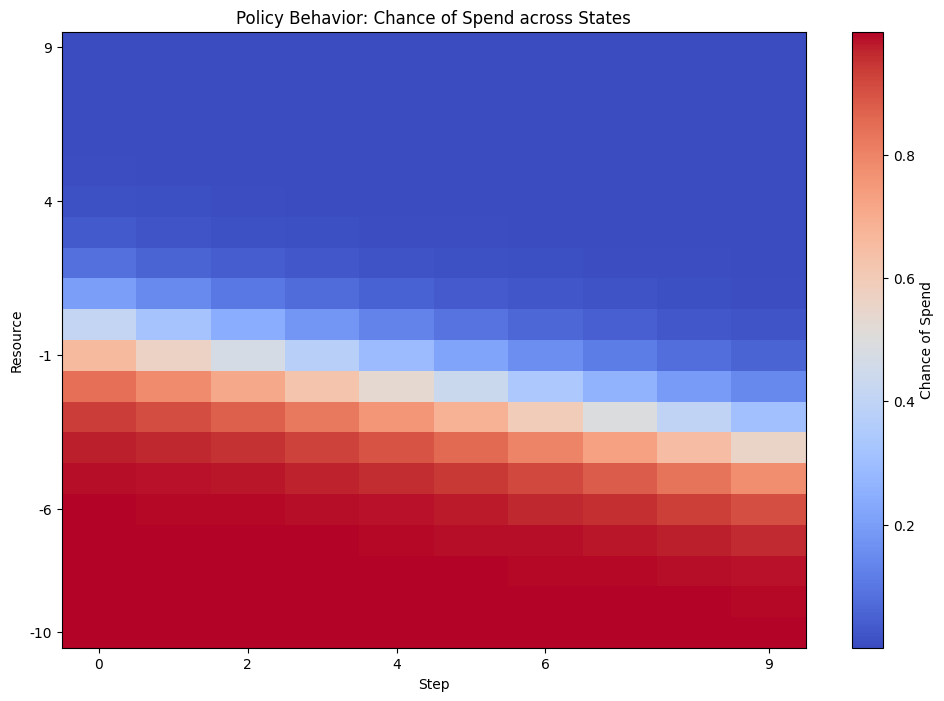

In [191]:
torch.manual_seed(69)
simplePolicy = SimplePolicy(2, 2)
print(simplePolicy.fc.weight, simplePolicy.fc.bias)
simplePolicy.plot_policy_heatmap()

In [192]:
# import torch

# # Your tensor of probabilities
# probs = torch.tensor([[0.09, 0.01, 0.9]])

# one_count = 0

# for i in range(1000):
#     if sampled_index == 1:
#         one_count += 1

[10  0]


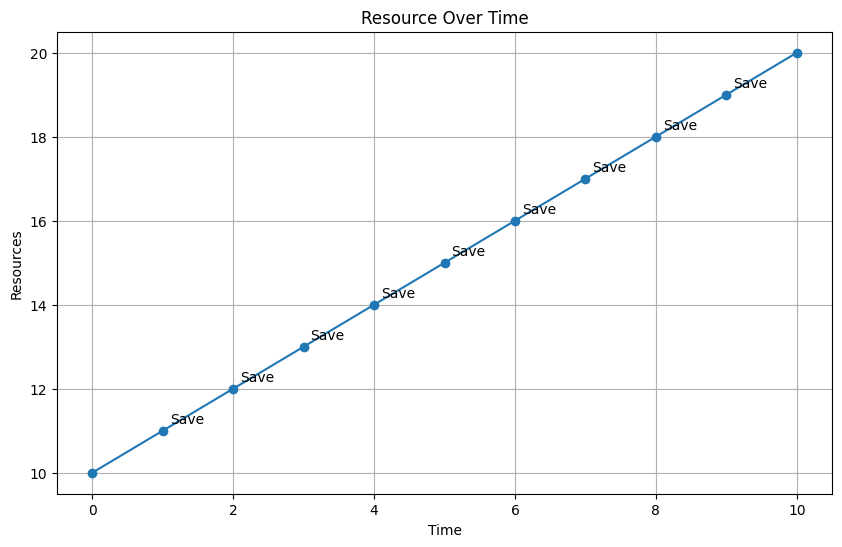

Final state - Time: 10, Resources: 20


In [193]:
# Example usage
env = SimpleResourceGame()
state = env.reset()
print(state)

resources = [state[0]]  # Initial resource count
times = [0]  # Initial time step
actions = []

for t in range(1, 11):  # Run for 10 steps
    state = torch.FloatTensor(state)
    sampled_action = torch.multinomial(simplePolicy(state), num_samples=1).item()
    state, reward, done, _ = env.step(sampled_action)
    resources.append(state[0])
    times.append(t)
    actions.append('Spend' if sampled_action == 1 else 'Save')
    if done:
        break

plot_rewards(times, resources, actions)

In [211]:
import torch.optim as optim

def train_policy(env, episodes=1000, lr=0.01):
    input_dim = 2  # resources and step_count
    output_dim = 2  # save or spend
    policy = SimplePolicy(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action = torch.argmax(action_probs).item()
            
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Compute loss and update policy
            loss = -1 * torch.log(action_probs[action]) * reward
            optimizer.zero_grad()

            if episode == 0 and (state[1] % 10 == 0 or state[1] < 10):
                print(f"state: {state}, action: {action}, loss: {loss}")
                print(policy.fc.weight, policy.fc.bias)
            #     policy.plot_policy_heatmap()

            loss.backward()

            optimizer.step()
            
            state = next_state
            
            if done:
                break
        
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")
        #     policy.plot_policy_heatmap()
        # elif episode + 1 < 10:
        #     policy.plot_policy_heatmap()
        #     print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return policy

state: [10  0], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


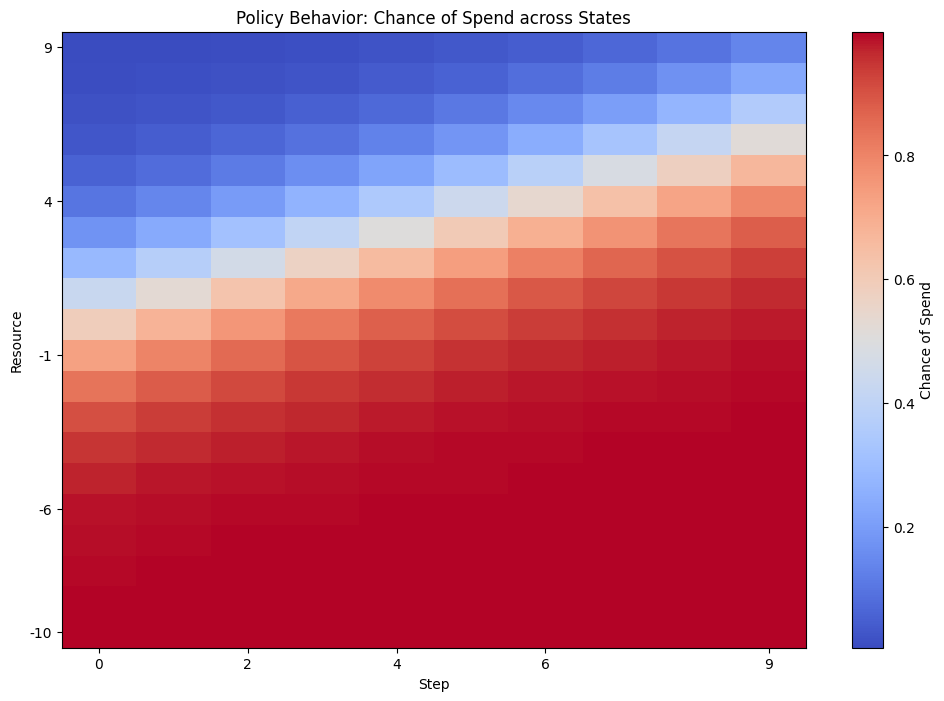

state: [11  1], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


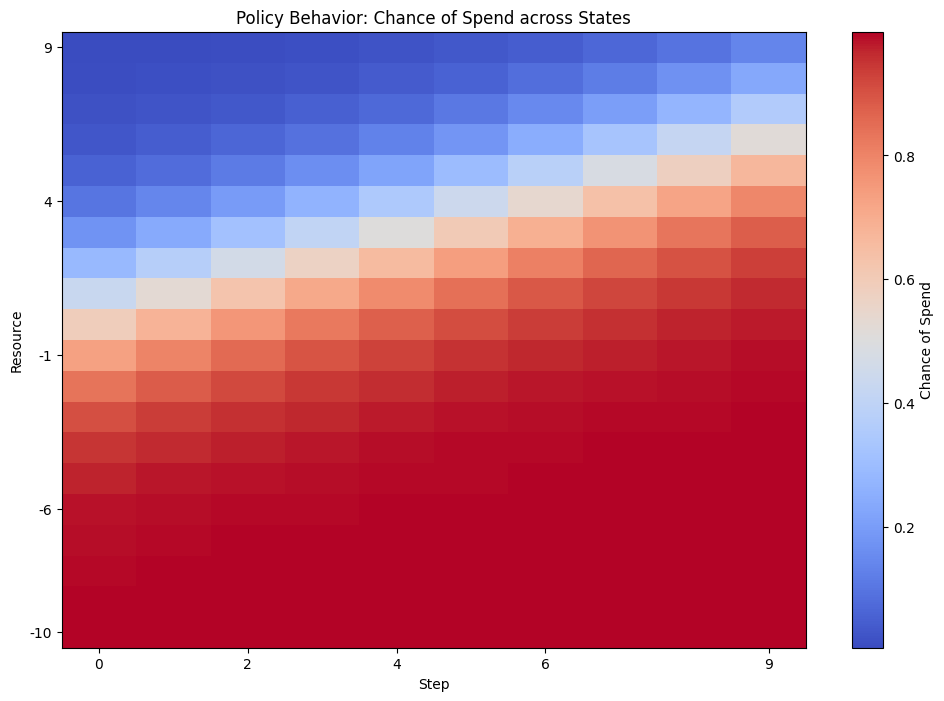

state: [12  2], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


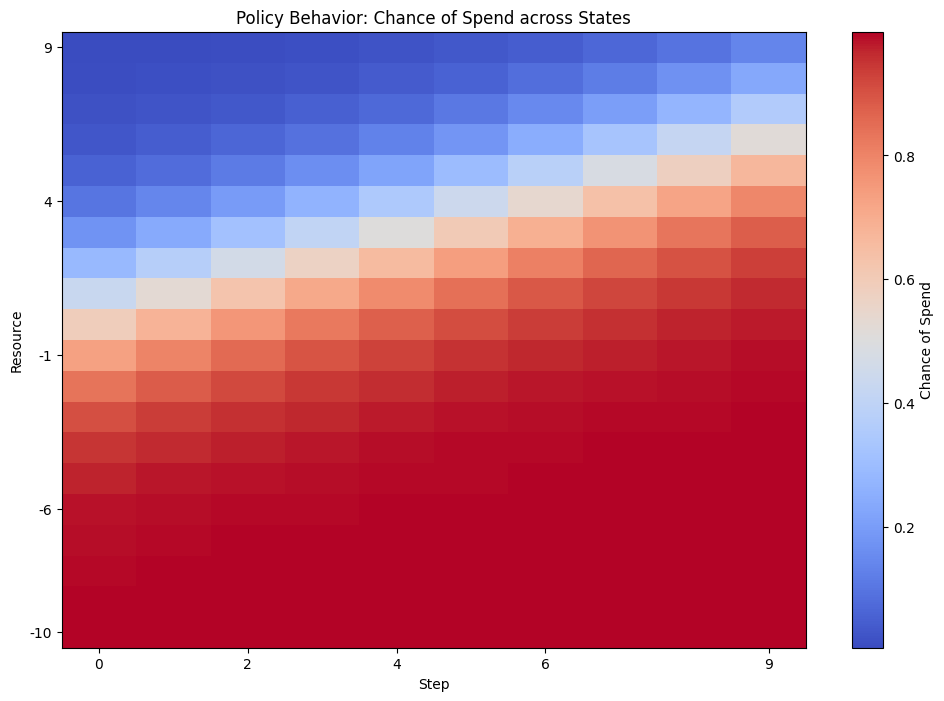

state: [13  3], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


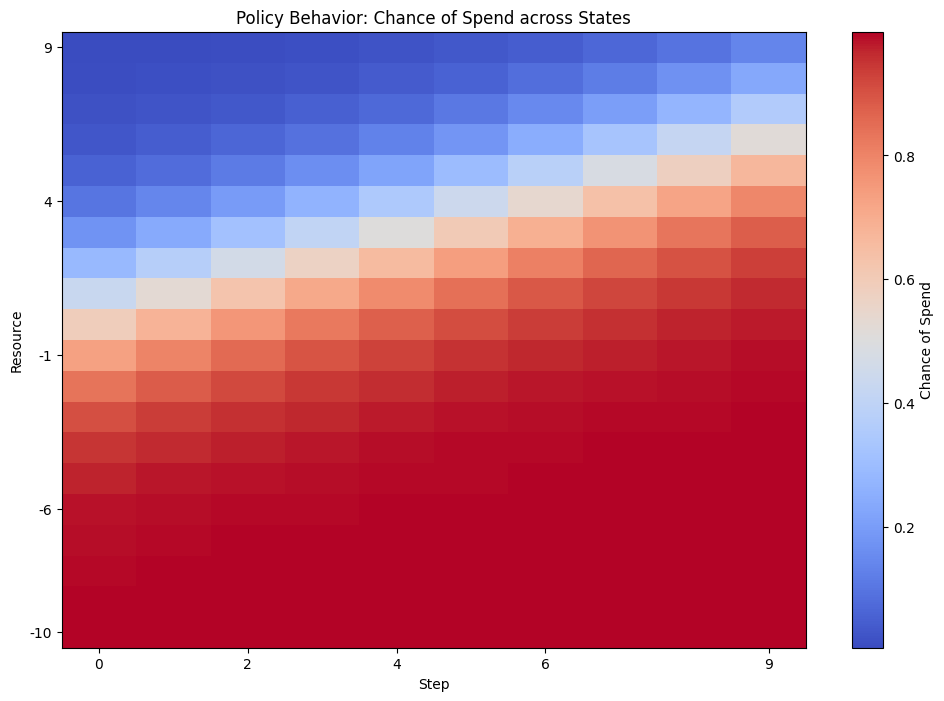

state: [14  4], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


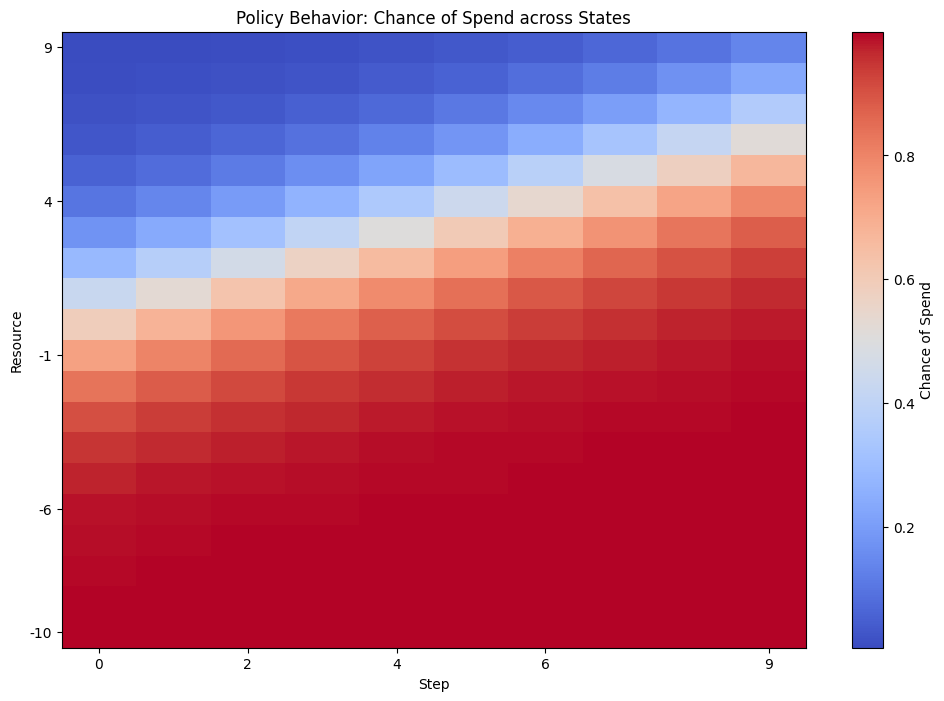

state: [15  5], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


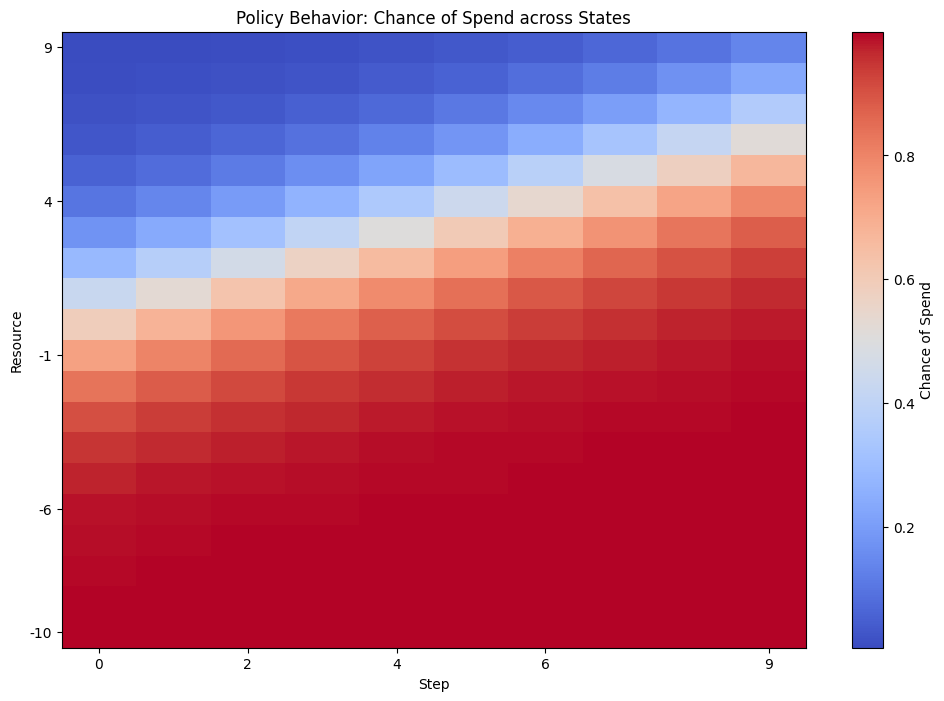

state: [16  6], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


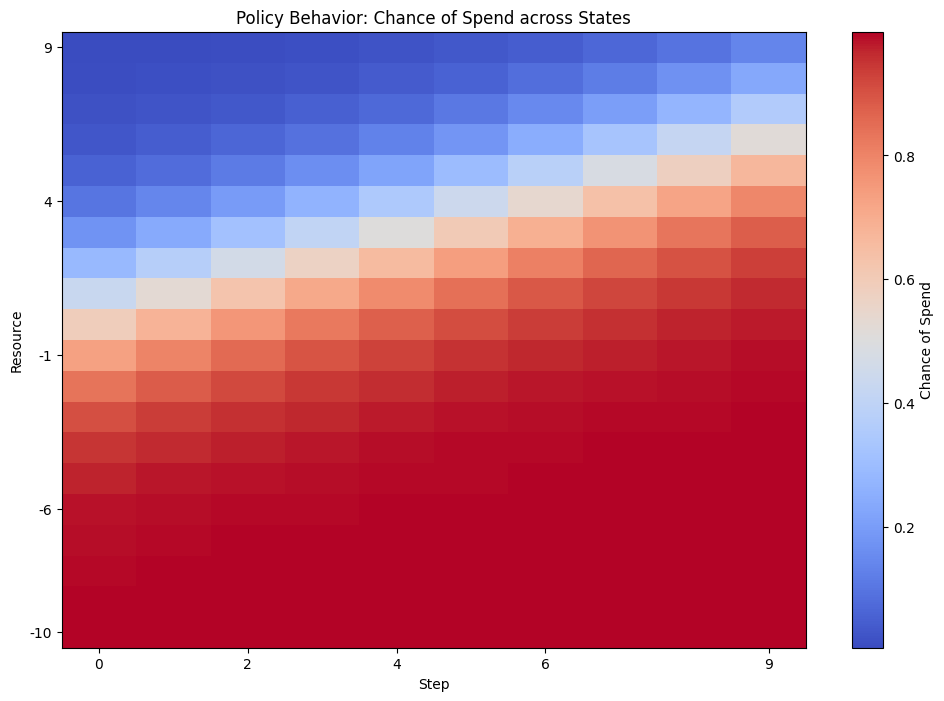

state: [17  7], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


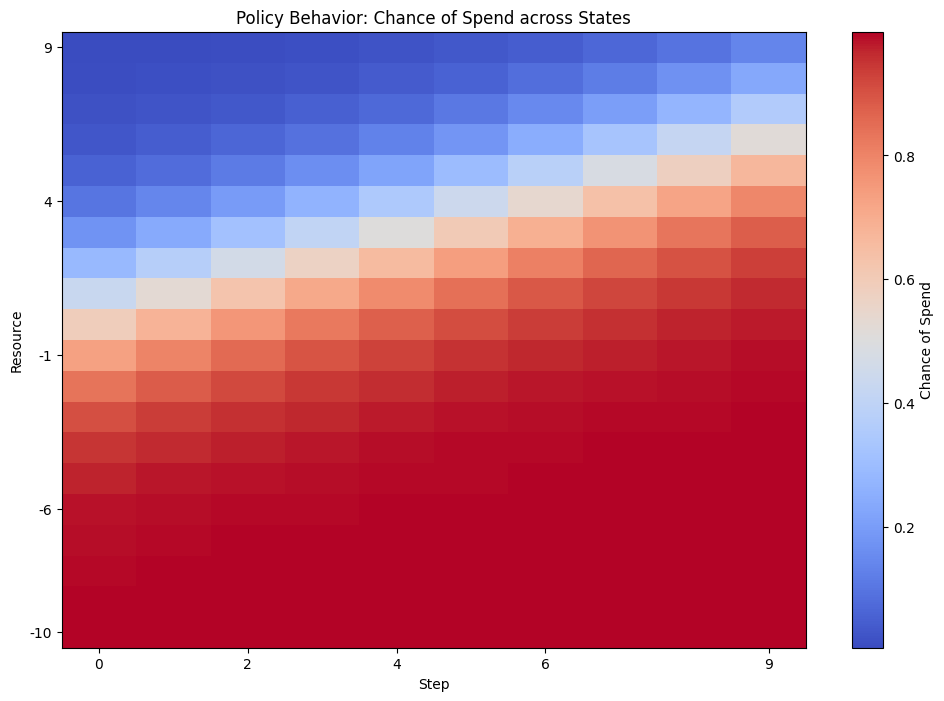

state: [18  8], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


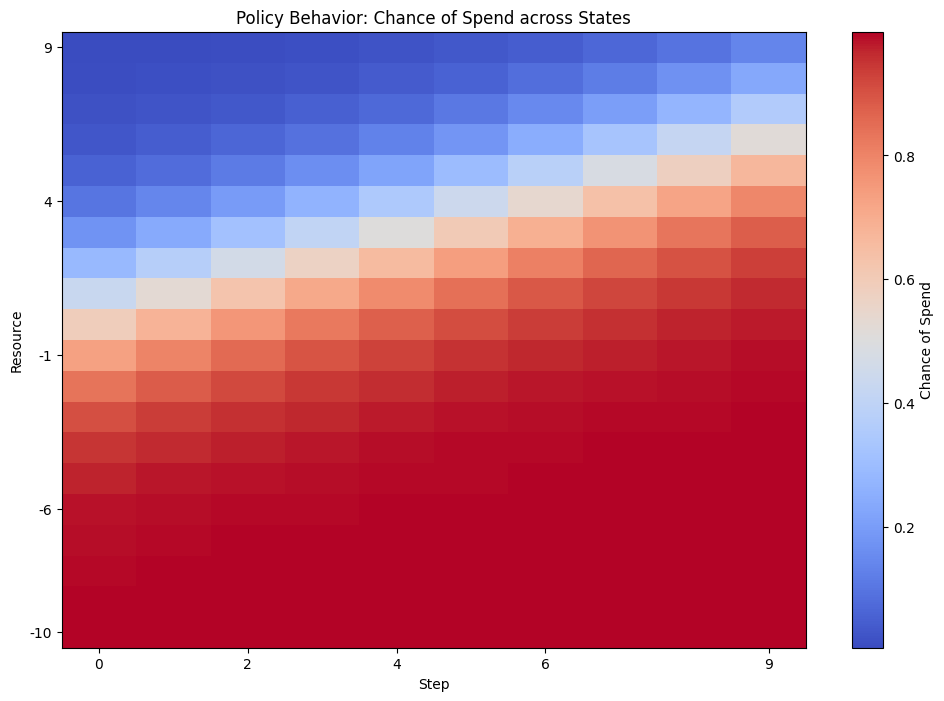

state: [19  9], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


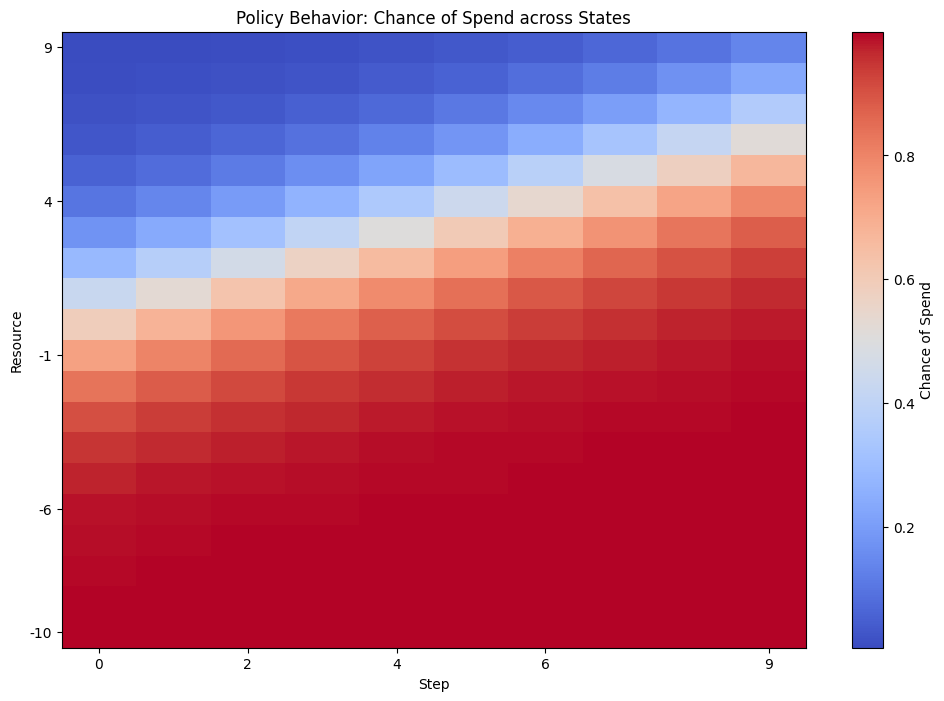

state: [20 10], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


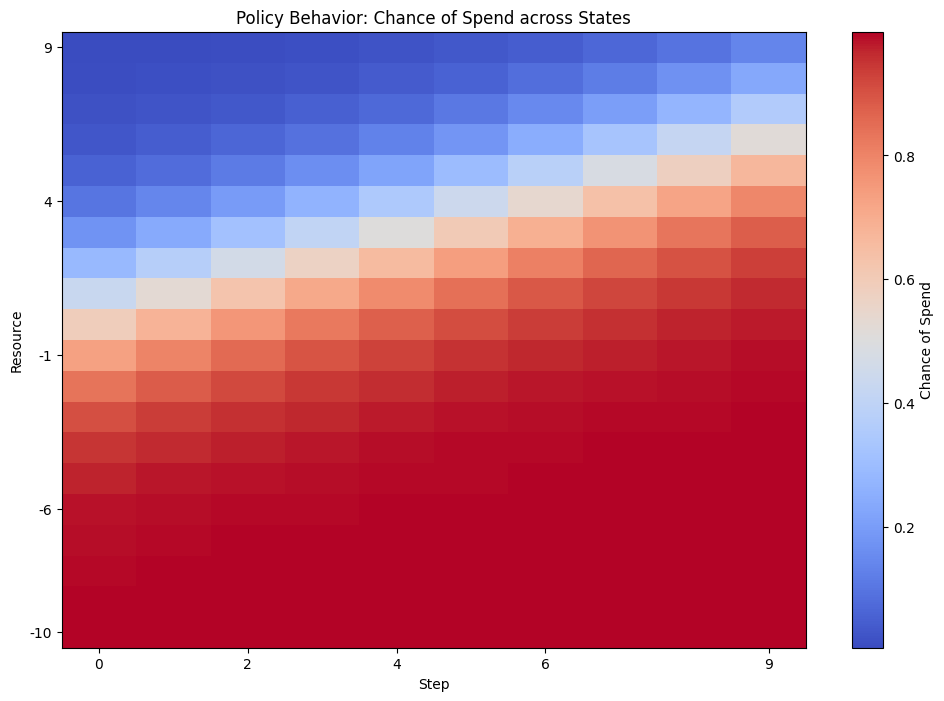

state: [30 20], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


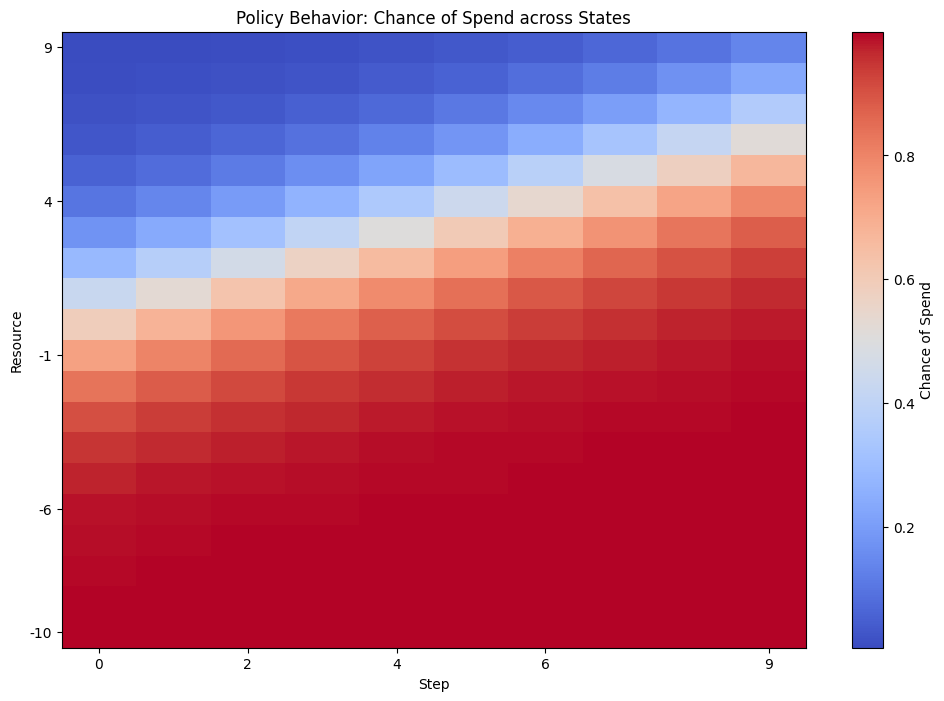

state: [40 30], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


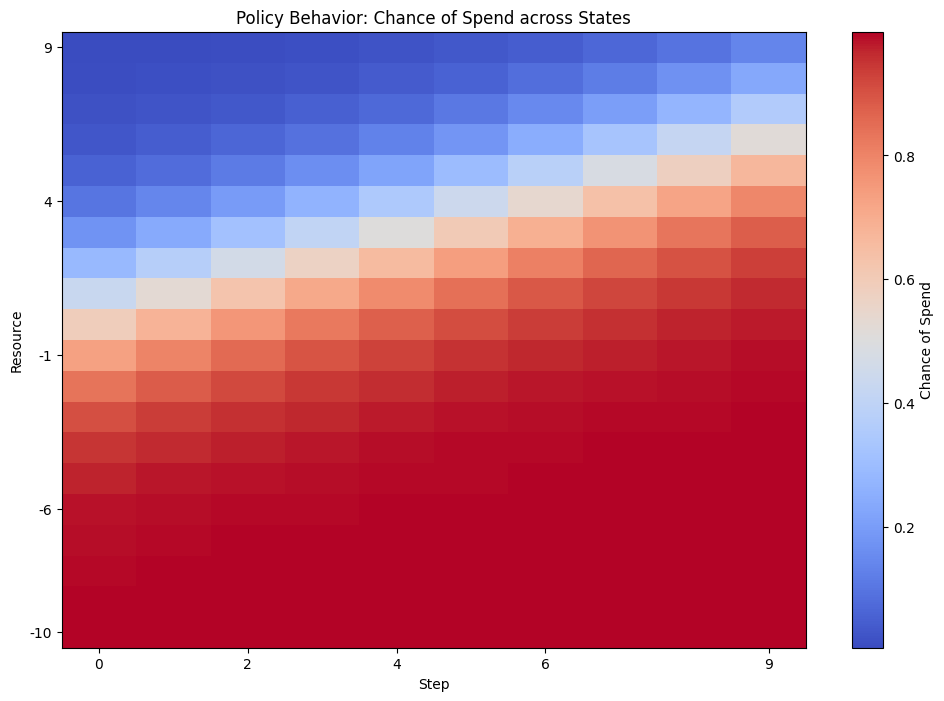

state: [50 40], action: 0, loss: 0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


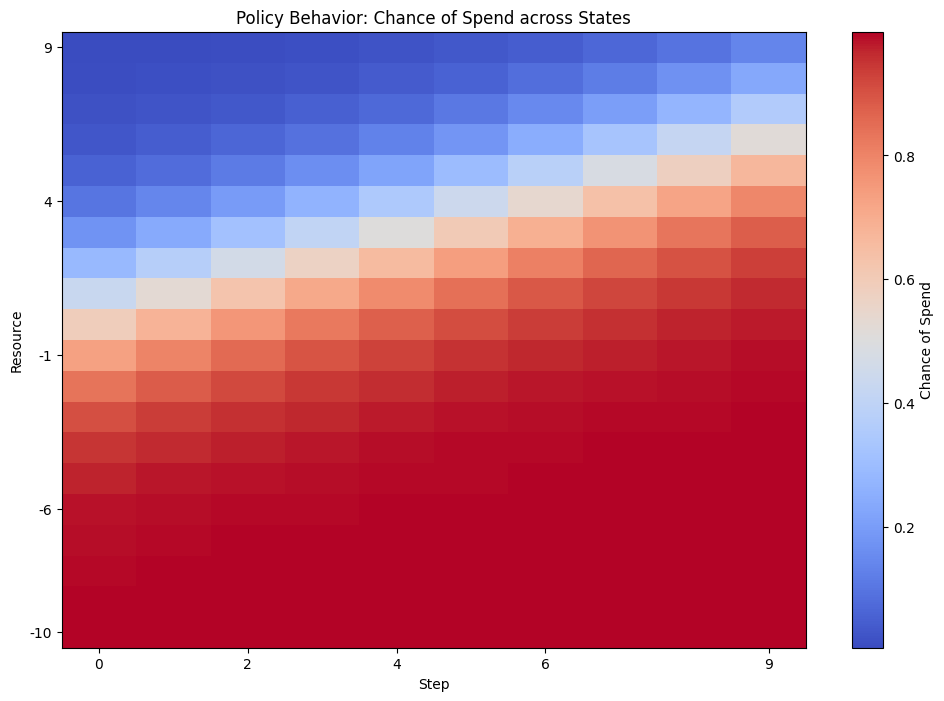

state: [60 50], action: 0, loss: -0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


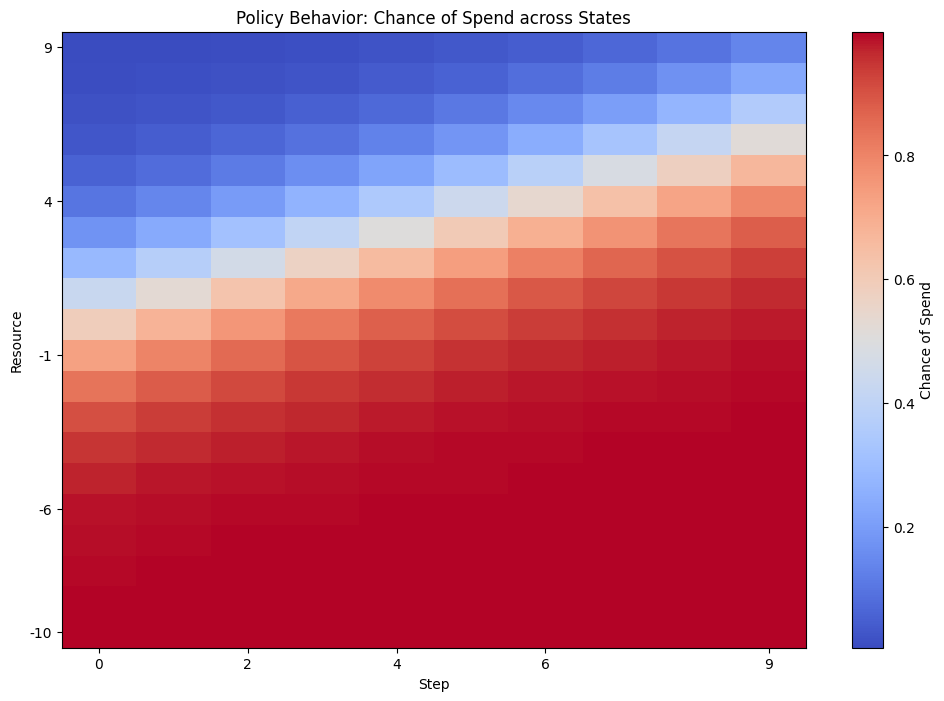

state: [70 60], action: 0, loss: -0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


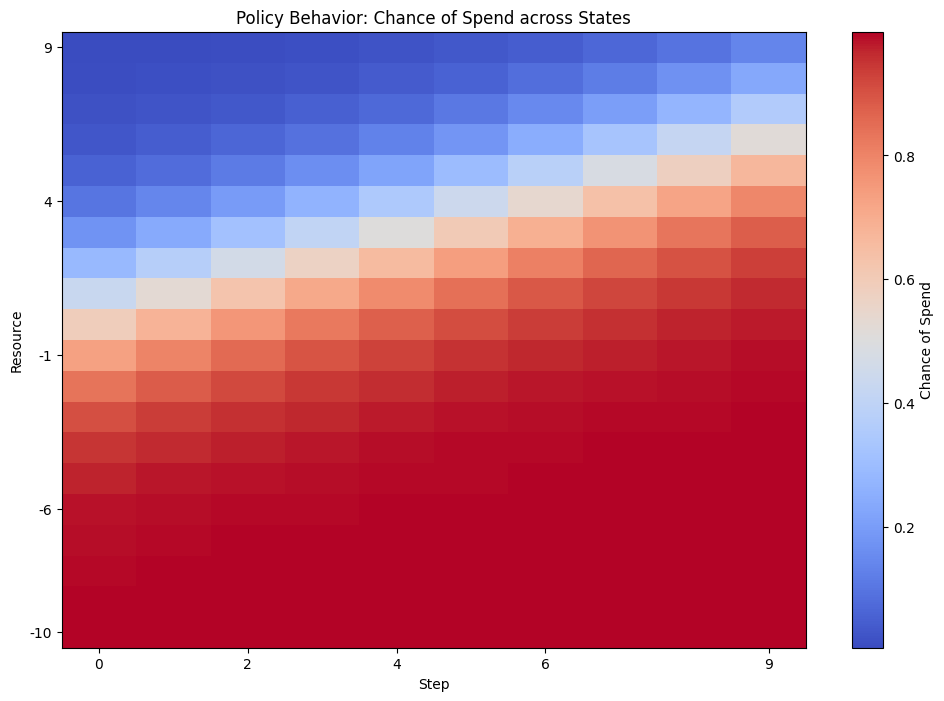

state: [80 70], action: 0, loss: -0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


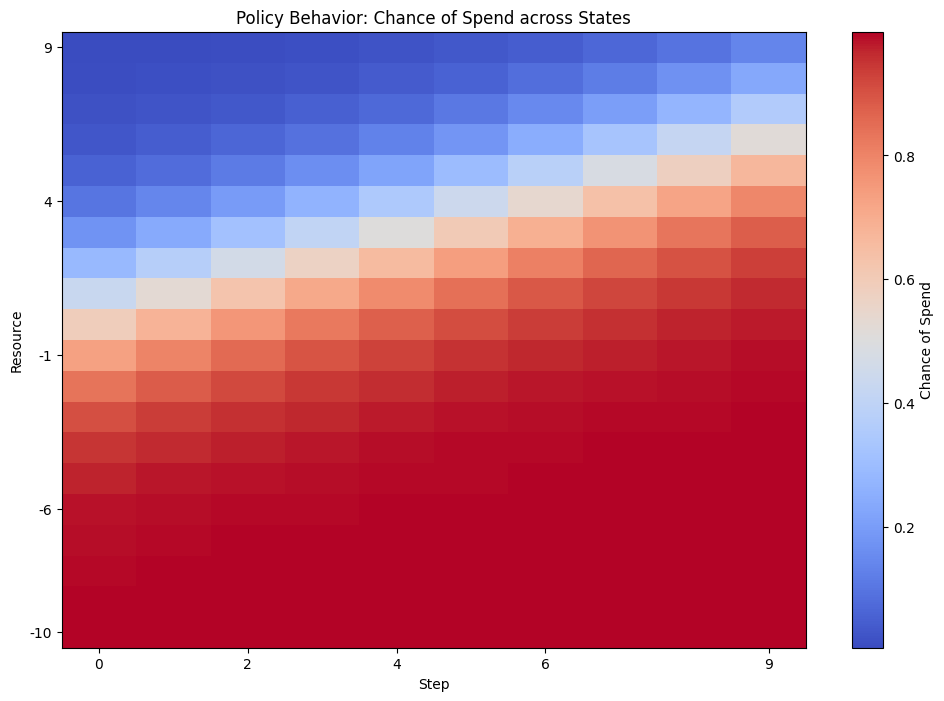

state: [90 80], action: 0, loss: -0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


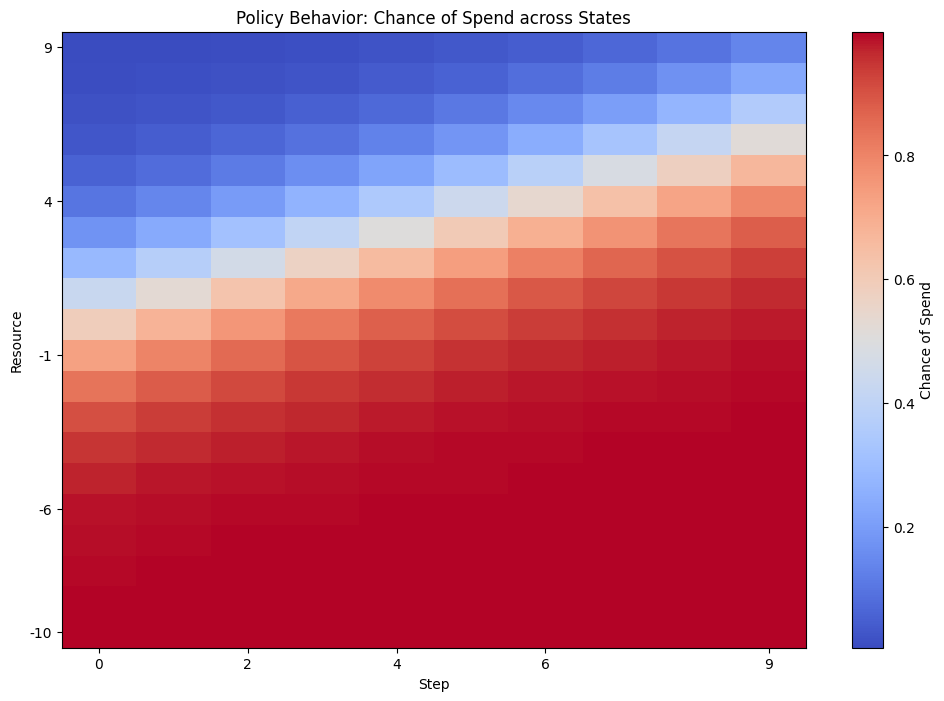

state: [100  90], action: 0, loss: -0.0
Parameter containing:
tensor([[ 0.5302, -0.5512],
        [-0.1051, -0.1600]], requires_grad=True) Parameter containing:
tensor([-0.4400, -0.0834], requires_grad=True)


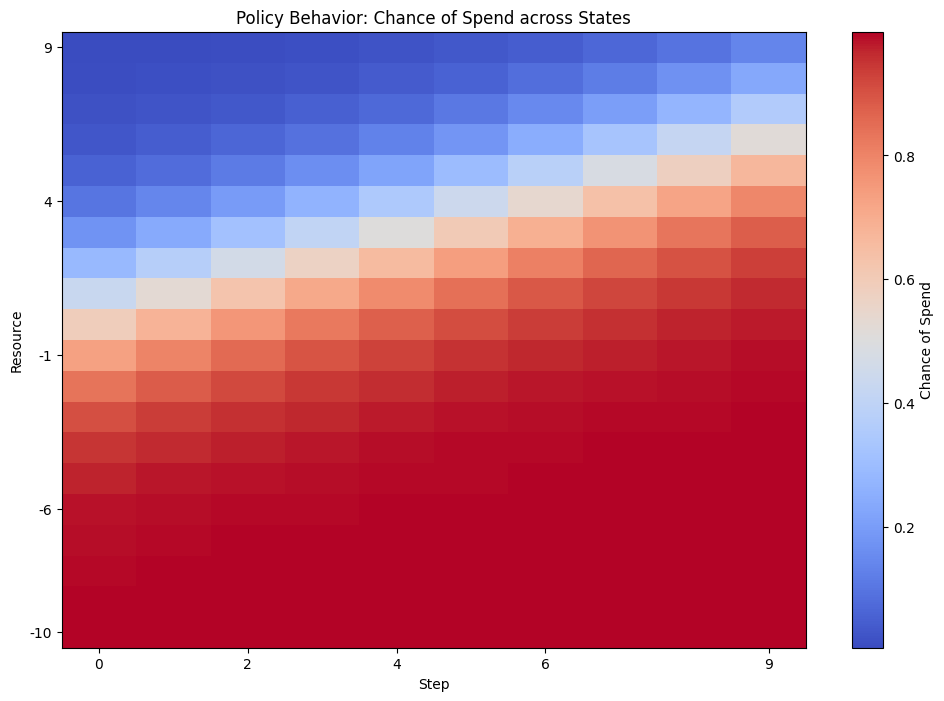

In [210]:
# Train the agent
env = SimpleResourceGame()
trained_policy = train_policy(env)

Episode 1 Reward: 35, Actions: 1111111111011011011011011011011011
Episode 2 Reward: 48, Actions: 1111111111011011011011011011011011
Episode 3 Reward: 35, Actions: 1111111111011011011011011011011011
Episode 4 Reward: 38, Actions: 1111111111011011011011011011011011
Episode 5 Reward: 38, Actions: 1111111111011011011011011011011011
Episode 6 Reward: 40, Actions: 1111111111011011011011011011011011
Episode 7 Reward: 40, Actions: 1111111111011011011011011011011011
Episode 8 Reward: 33, Actions: 1111111111011011011011011011011011
Episode 9 Reward: 33, Actions: 1111111111011011011011011011011011
Episode 10 Reward: 36, Actions: 1111111111011011011011011011011011
Episode 11 Reward: 50, Actions: 1111111111011011011011011011011011
Episode 12 Reward: 45, Actions: 1111111111011011011011011011011011
Episode 13 Reward: 38, Actions: 1111111111011011011011011011011011
Episode 14 Reward: 47, Actions: 1111111111011011011011011011011011
Episode 15 Reward: 45, Actions: 1111111111011011011011011011011011
Epis

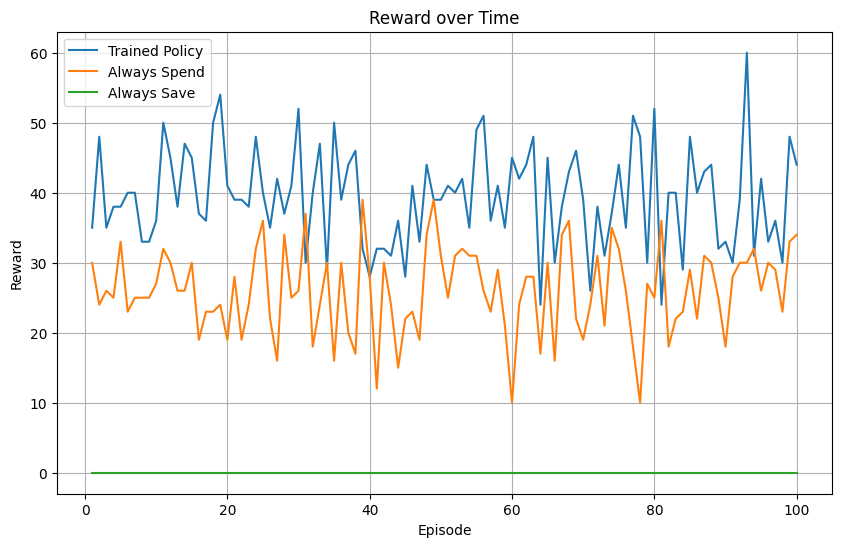

In [21]:
# Test the trained policy
test_episodes = 100
total_rewards = []
episode_numbers = []

# Add policies for always spend and always save
always_spend_rewards = []
always_save_rewards = []

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    always_spend_reward = 0
    always_save_reward = 0
    done = False
    actions = []
    
    while not done:
        state_tensor = torch.FloatTensor(state)
        action_probs = trained_policy(state_tensor)
        action = torch.argmax(action_probs).item()
        actions.append(action)
        state, reward, done, _ = env.step(action)
        episode_reward += reward

        if action == 1:
            spend_reward = reward
            save_reward = 
        else:

        # Always spend policy
        _, spend_reward, _, _ = env.step(1)
        always_spend_reward += spend_reward

        # Always save policy
        _, save_reward, _, _ = env.step(0)
        always_save_reward += save_reward
    
    total_rewards.append(episode_reward)
    always_spend_rewards.append(always_spend_reward)
    always_save_rewards.append(always_save_reward)
    episode_numbers.append(episode + 1)
    print(f"Episode {episode + 1} Reward: {episode_reward}, Actions: {''.join(map(str, actions))}")

print(f"Average Reward over {test_episodes} test episodes: {np.mean(total_rewards):.2f}")
print(f"Average Reward for always spend policy: {np.mean(always_spend_rewards):.2f}")
print(f"Average Reward for always save policy: {np.mean(always_save_rewards):.2f}")
print(f"Percentage of 'Spend' actions: {sum(actions) / len(actions) * 100:.2f}%")

# Plot reward over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, total_rewards, label='Trained Policy')
plt.plot(episode_numbers, always_spend_rewards, label='Always Spend')
plt.plot(episode_numbers, always_save_rewards, label='Always Save')
plt.title('Reward over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()